In [1]:
import glob, sys
import numpy as np
import matplotlib.pyplot as plt
import time
import pyccl as ccl
cosmo = ccl.Cosmology(Omega_c = 0.30711 - 0.048254, Omega_b = 0.048254, h = 0.677, sigma8 = 0.8288, n_s=0.96)

In [2]:
%load_ext autoreload
%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import CL_COUNT_class_cluster_abundance as cl_count

initialize the `ClusterAbundance` object

In [3]:
clc = cl_count.ClusterAbundance()
#choose the halo mass function and mass definition
massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncDespali16(cosmo, mass_def=massdef)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25)*4*np.pi
clc.f_sky = clc.sky_area/4*np.pi

# Binned approach
Compute the 2D integral

## model

$$
N_{\alpha\beta}^{\rm predicted} = \Omega_s\int_{z_\alpha}^{z_{\alpha + 1}} dz\int_{\log_{10}M_\beta}^{\log_{10}M_{\beta + 1}}\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}d\log_{10}M
$$

define mass & redshift binning

In [4]:
z_corner = np.linspace(0.25, 1.25, 10)
logm_corner = np.linspace(14, 14.8, 10)
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
Z_bin = binning(z_corner)
logMass_bin = binning(logm_corner)

In [5]:
#define redshift-mass grid
z_grid = np.linspace(0., 3, 300)
logm_grid = np.linspace(12,16, 300)

`simps`

### Abundance prediction

In [6]:
t0 = time.time()
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
Abundance_simps = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')
t1 = time.time()
print('time (seconds) = ' + str(t1-t0))
time_simps = t1-t0

time (seconds) = 0.3289761543273926


### Sample covariance

In [7]:
halobais_model = ccl.halos.hbias.HaloBiasTinker10(cosmo, mass_def=massdef, mass_def_strict=True)
clc.compute_halo_bias_grid_MZ(z_grid = z_grid, logm_grid = logm_grid, halobiais = halobais_model)
Binned_halo_bias = clc.halo_bias_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, N_th = Abundance_simps)
sample_covariance = clc.sample_covariance_MZ(Z_bin, logMass_bin, Abundance_simps, Binned_halo_bias)

### Shot noise

In [8]:
shot_noise_variance = np.diag(Abundance_simps.flatten())

In [9]:
covariance = sample_covariance + shot_noise_variance

## data

In [10]:
x_th_SV = np.random.multivariate_normal(Abundance_simps.flatten(), sample_covariance)

In [11]:
N_obs = np.random.poisson(lam=x_th_SV)

In [12]:
delta_map = x_th_SV

## Likelihood

In [13]:
%load_ext autoreload
%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import CL_COUNT_class_likelihood as lnL

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
Likelihood = lnL.Likelihood()

### Binned Poisson/Gaussian Mixture (diagonal covariance matrix)

$L = \prod_i^N\int dx_i \mathcal{P}(\widehat{N}_i| x_i)\times \mathcal{G}(x_i|\mu_i, \sigma_{SV,i}^2)$

In [15]:
lnL_Binned_MPG_diagonal = Likelihood.lnLikelihood_Binned_MPG_diagonal(Abundance_simps.flatten(), N_obs, sample_covariance.diagonal())
print(Likelihood.lnL_Binned_MPG_diagonal)

-412.24036518574445


### Binned Poisson/Gaussian Mixture (estimator, full covariance matrix)

$L = \int d\vec{x} \prod_i^N\mathcal{P}(\widehat{N}_i| x_i)\times \mathcal{G}(\vec{x}|\vec{\mu}, \Sigma_{SV}) \rightarrow \widehat{L} = \frac{1}{N_{sample}} \sum_{j= 1}^{N_{sample}}\prod_i^N\mathcal{P}(\widehat{N}_i| x_{i,j}) $

where $x_{i,j}$ is the $j-$th random realisation of the $i-$th cluster abundance bin, following the Gaussian distribution $\mathcal{G}(.|\vec{\mu}, \Sigma_{SV})$ 

In [16]:
lnL_Binned_MPG_delta = Likelihood.lnLikelihood_Binned_MPG_delta(Abundance_simps.flatten(), N_obs, sample_covariance)
print(Likelihood.lnL_Binned_MPG_delta)

-413.0132969271447


### Binned Poisson/Gaussian Mixture (approximation)

In [17]:
lnL_Binned_MPG_approx = Likelihood.lnLikelihood_Binned_MPG_approx(Abundance_simps.flatten(), N_obs, sample_covariance)
print(Likelihood.lnL_Binned_MPG_approx)

-411.9733771856497


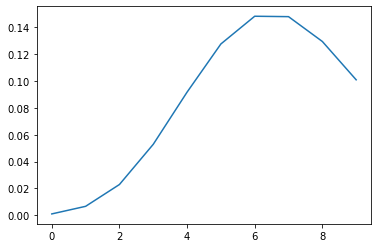

In [18]:
N = np.arange(10)
P = np.zeros(len(N))
for i,n in enumerate(N):
    Likelihood.lnLikelihood_Binned_MPG_approx(np.array([7]),np.array([n]), np.array([.1]))
    P[i] = np.exp(Likelihood.lnL_Binned_MPG_approx)
plt.plot(N, P)

### Binned Gaussian

$L = \mathcal{G}(\vec{\widehat{N}}|\vec{\mu}, \Sigma_{SV})$

In [19]:
lnL_Binned_Gaussian = Likelihood.lnLikelihood_Binned_Gaussian(Abundance_simps, N_obs.reshape(len(Z_bin), len(logMass_bin)), covariance)
print(Likelihood.lnL_Binned_Gaussian)

-39.51701489855843


### Binned Poisson

$L = \prod_i^N\mathcal{P}(\widehat{N}_i| \mu_i)$

In [20]:
lnL_Binned_Poissonian = Likelihood.lnLikelihood_Binned_Poissonian(Abundance_simps, N_obs.reshape(len(Z_bin), len(logMass_bin)))
print(Likelihood.lnL_Binned_Poissonian)

1774360.1881460054


# Unbinned Approach

## data

In [21]:
#Generate mass, redshift catalog
n_cluster = 100000
redshift, M200c = np.random.random(n_cluster)*(1 - 0.2) + 0.2, 10**(np.random.random(n_cluster)*(15 - 13) + 13)

## model

$$
\lambda(m_i, z_i) = \Omega_s\frac{d^2V(z_i)}{dz d\Omega}\frac{dn(M_i,z_i)}{d\log_{10}M}
$$

In [22]:
t0 = time.time()
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
multiplicity_interp = clc.multiplicity_function_individual_MZ(z = redshift, logm = np.log10(M200c), method = 'interp')
t1 = time.time()
print('time (seconds) = ' + str(t1-t0))

time (seconds) = 0.2156980037689209


In [23]:
N_tot = clc.Cluster_Abundance_MZ(Redshift_bin = [[.2, 1]], Proxy_bin = [[13,15]], method = 'simps')[0][0]

## Likelihood

$\log L = \sum_i^N \log\lambda(m_i, z_i) - N_{tot}$

In [24]:
Likelihood.lnLikelihood_UnBinned_Poissonian(multiplicity_interp, N_tot)
print(Likelihood.lnL_UnBinned_Poissonian)

-4698975.213671311
